<a href="https://colab.research.google.com/github/brajeshkumar7/wallet_risk_scoring/blob/main/wallet_risk_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA

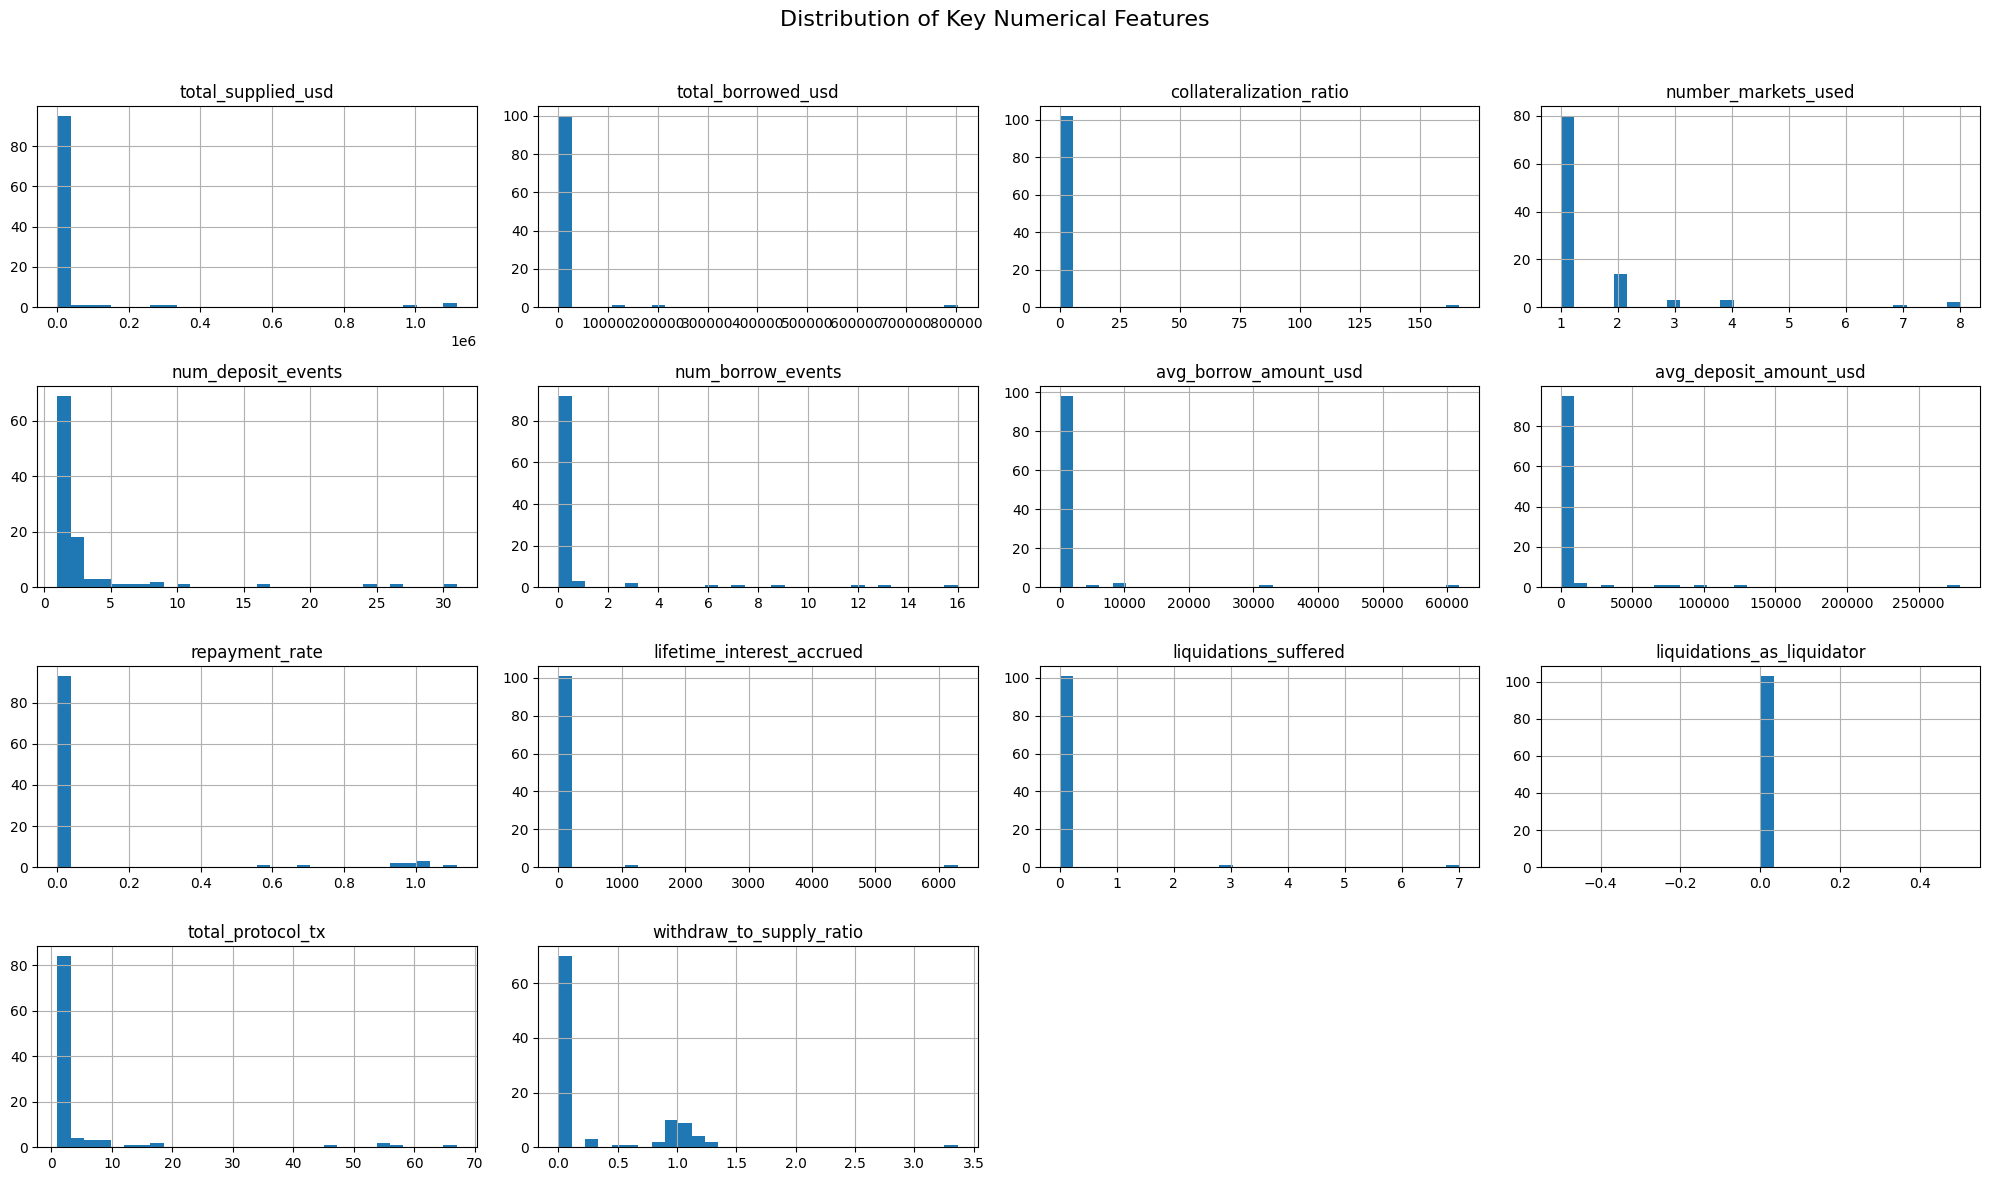

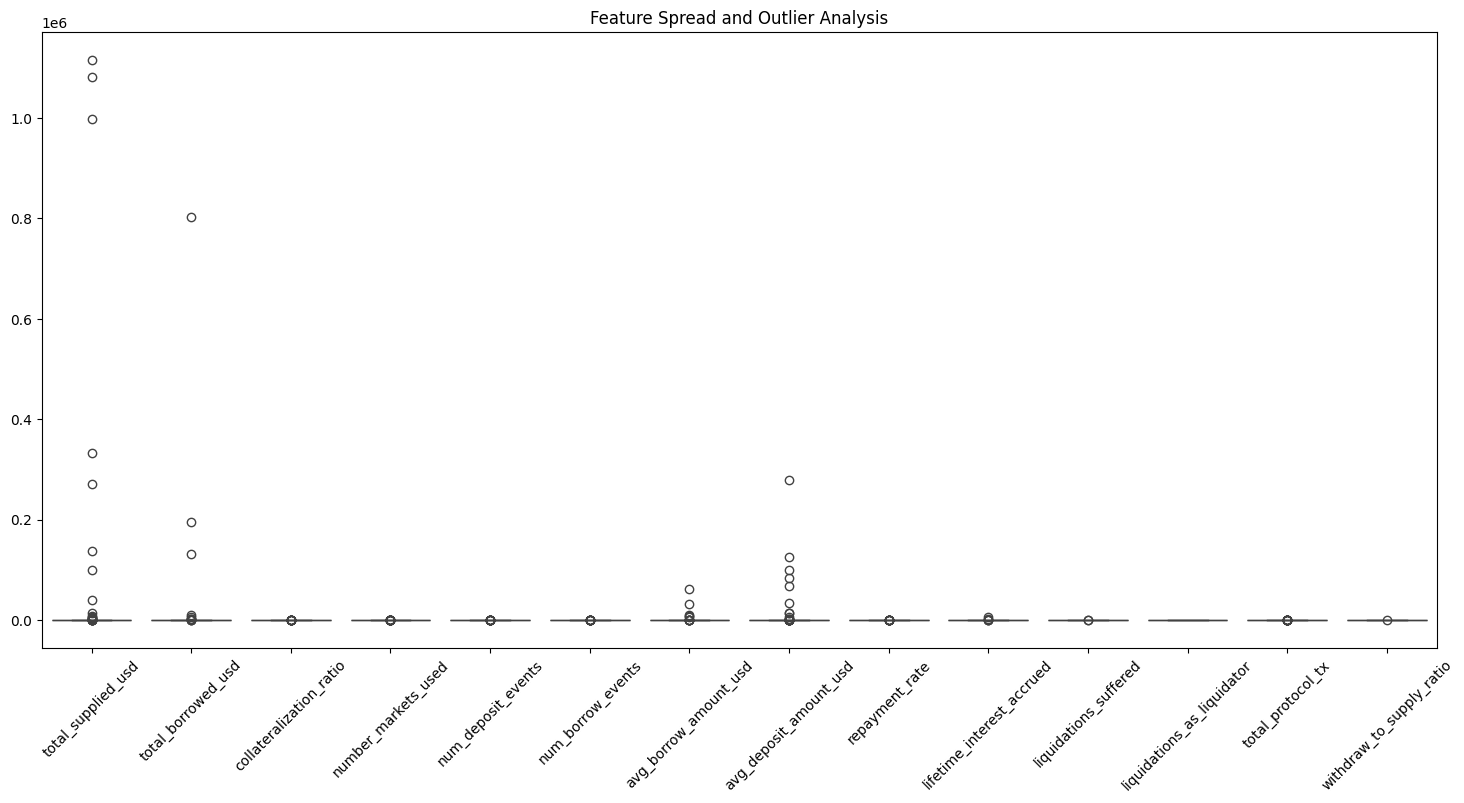

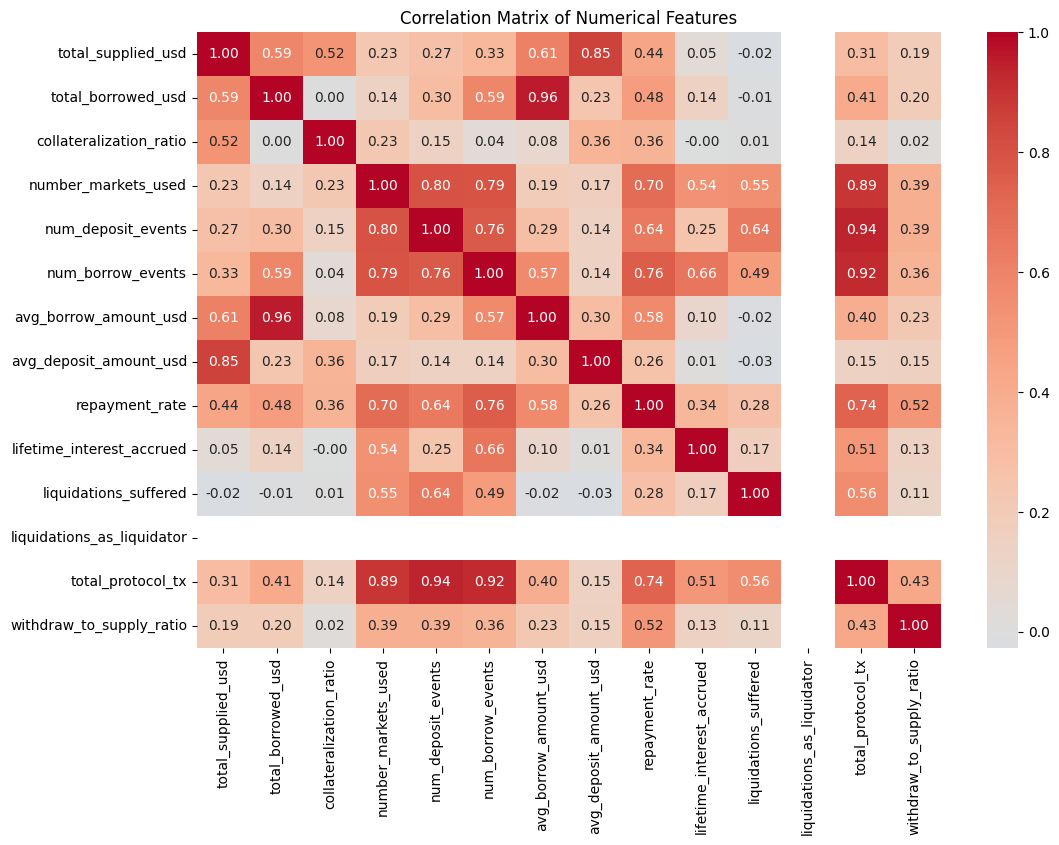

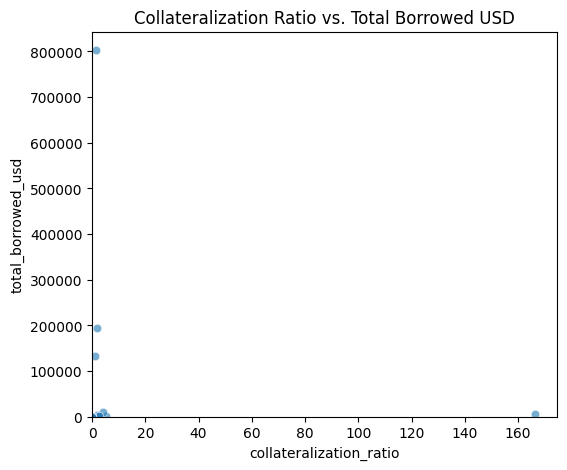

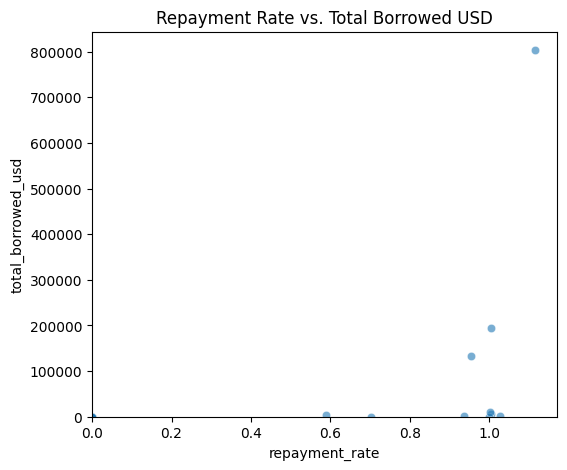

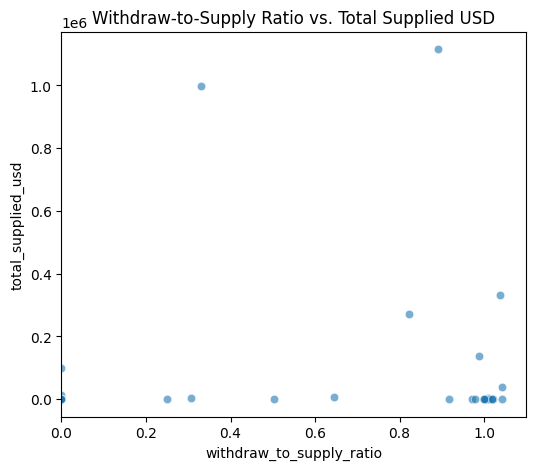

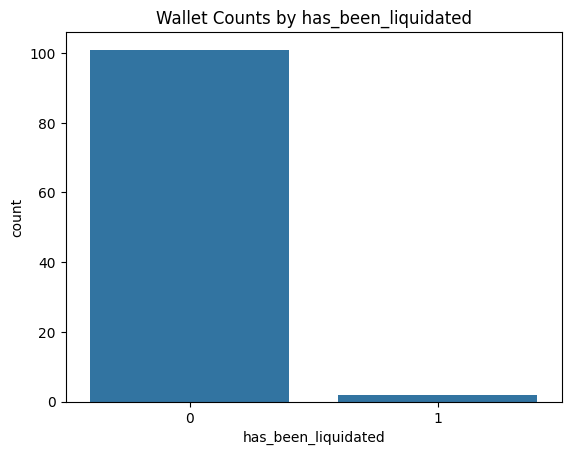

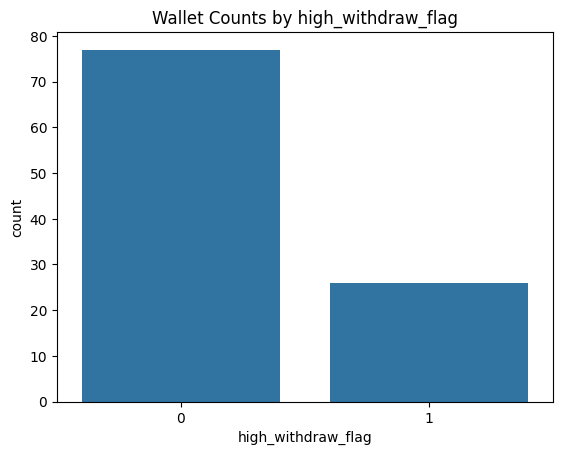

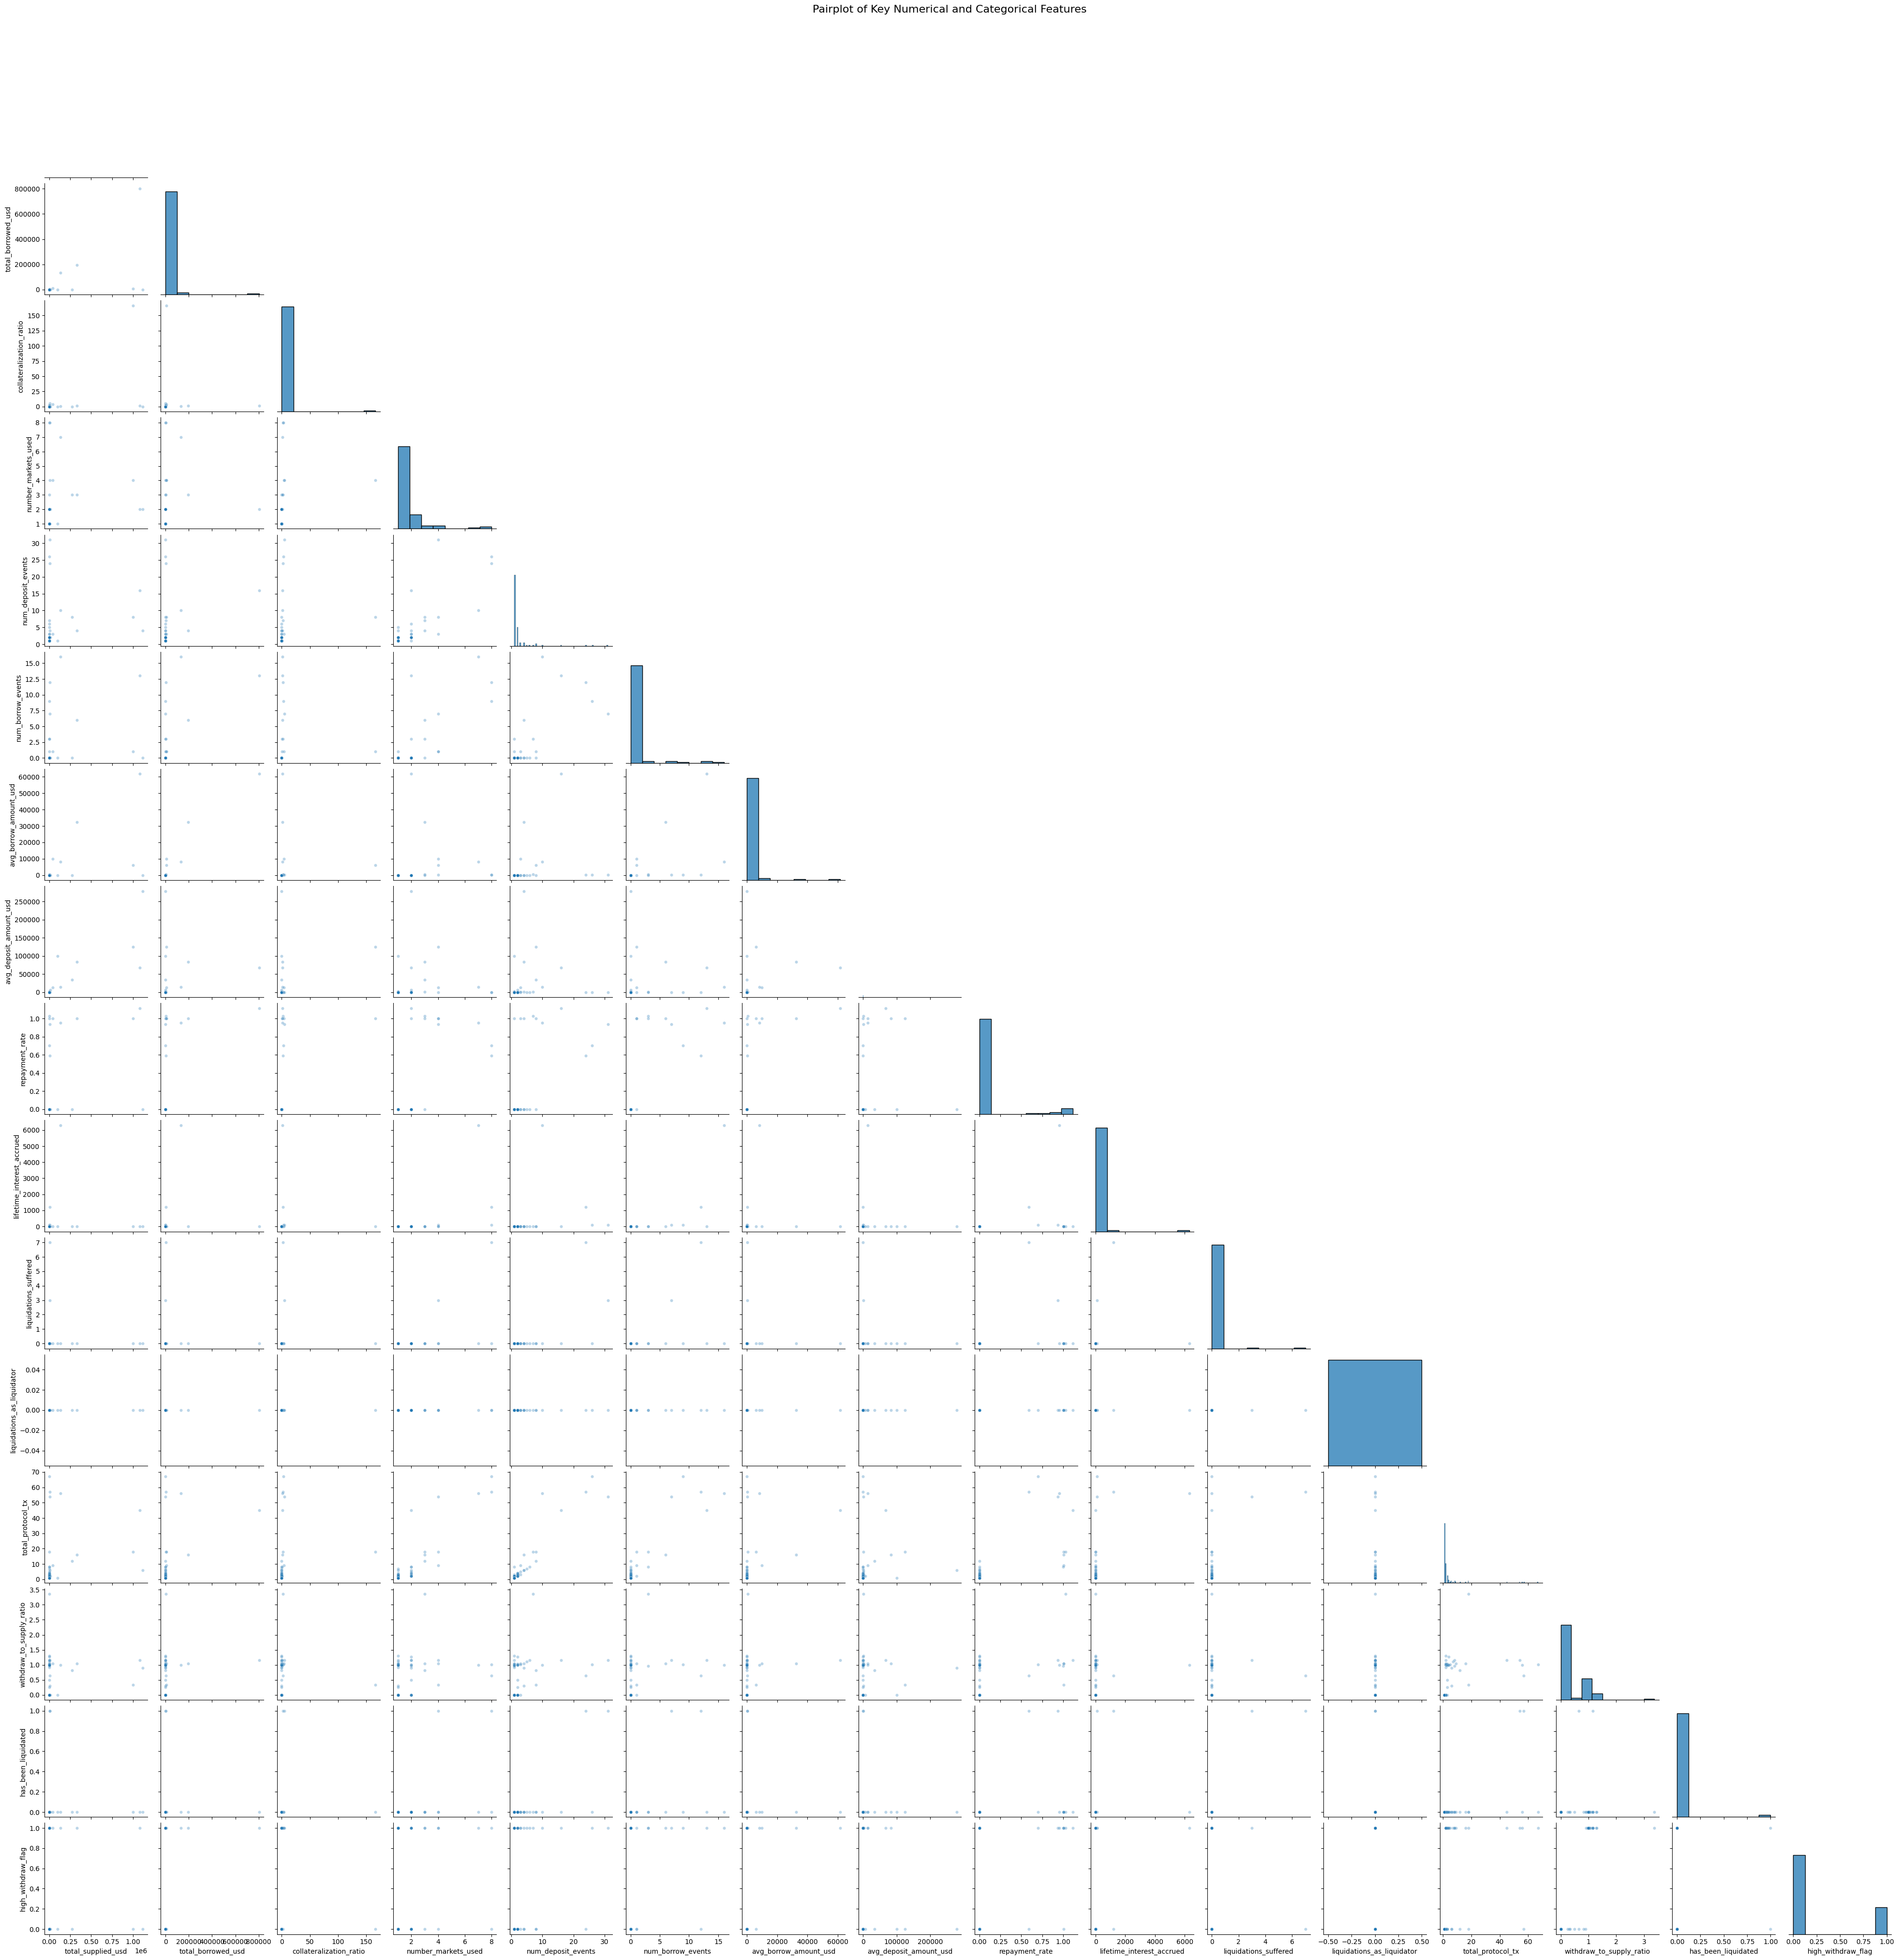

Please upload the PNG/JPG of any plots you would like me to analyze.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the dataset
dataset = pd.read_csv("engineered_features_dataFile.csv")

# 2. Define features of interest for analysis
numerical_features = [
    "total_supplied_usd", "total_borrowed_usd", "collateralization_ratio",
    "number_markets_used", "num_deposit_events", "num_borrow_events",
    "avg_borrow_amount_usd", "avg_deposit_amount_usd",
    "repayment_rate", "lifetime_interest_accrued",
    "liquidations_suffered", "liquidations_as_liquidator",
    "total_protocol_tx", "withdraw_to_supply_ratio",
]

categorical_features = [
    "has_been_liquidated", "high_withdraw_flag"
]

# 3. Plot histograms to visualize feature distributions
dataset[numerical_features].hist(bins=30, figsize=(20, 12), layout=(4, 4))
plt.suptitle("Distribution of Key Numerical Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 4. Create boxplots to identify outliers and feature spread
plt.figure(figsize=(18, 8))
sns.boxplot(data=dataset[numerical_features])
plt.xticks(rotation=45)
plt.title("Feature Spread and Outlier Analysis")
plt.show()

# 5. Generate a correlation heatmap (excluding non-numeric columns)
plt.figure(figsize=(12, 8))
correlation_matrix = dataset[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# 6. Create scatter plots to explore relationships between key risk-related features
plt.figure(figsize=(6, 5))
sns.scatterplot(x="collateralization_ratio", y="total_borrowed_usd", data=dataset, alpha=0.6)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title("Collateralization Ratio vs. Total Borrowed USD")
plt.show()

plt.figure(figsize=(6, 5))
sns.scatterplot(x="repayment_rate", y="total_borrowed_usd", data=dataset, alpha=0.6)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title("Repayment Rate vs. Total Borrowed USD")
plt.show()

plt.figure(figsize=(6, 5))
sns.scatterplot(x="withdraw_to_supply_ratio", y="total_supplied_usd", data=dataset, alpha=0.6)
plt.xlim(0, 1.1)
plt.title("Withdraw-to-Supply Ratio vs. Total Supplied USD")
plt.show()

# 7. Plot count plots for categorical (flag) features
for feature in categorical_features:
    sns.countplot(x=feature, data=dataset)
    plt.title(f"Wallet Counts by {feature}")
    plt.show()

# 8. Create a pairplot for a comprehensive overview (sampling for larger datasets)
if len(dataset) < 2000:
    # Use the entire dataset if it's small enough
    data_sample = dataset[numerical_features + categorical_features].sample(frac=1.0)
else:
    # Otherwise, take a random sample for performance
    data_sample = dataset[numerical_features + categorical_features].sample(2000, random_state=42)
sns.pairplot(data_sample, corner=True, plot_kws=dict(alpha=0.3, s=20))
plt.suptitle("Pairplot of Key Numerical and Categorical Features", y=1.02, fontsize=16)
plt.show()

# 9. (Optional) Generate grouped boxplots if an 'activity_level' feature is present
if "activity_level" in dataset.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x="activity_level", y="collateralization_ratio", data=dataset)
    plt.title("Collateralization Ratio by Activity Level")
    plt.show()

print("Please upload the PNG/JPG of any plots you would like me to analyze.")

# DATA CLEANING BASED ON EDA

In [2]:
import pandas as pd
import numpy as np

def cap_outliers_by_quantile(dataframe, feature_columns, lower_q=0.05, upper_q=0.95):
    """
    Caps the values of specified columns to the lower and upper quantiles
    to mitigate the effect of outliers.
    """
    for col in feature_columns:
        if col in dataframe.columns:
            lower_bound = dataframe[col].quantile(lower_q)
            upper_bound = dataframe[col].quantile(upper_q)
            dataframe[col] = dataframe[col].clip(lower=lower_bound, upper=upper_bound)
    return dataframe

def apply_log_transformation(dataframe, feature_columns):
    """
    Applies a log(1 + x) transformation to specified columns to reduce skewness.
    """
    for col in feature_columns:
        if col in dataframe.columns:
            dataframe[col + '_log'] = np.log1p(dataframe[col].clip(lower=0))
    return dataframe

def drop_highly_correlated_features(dataframe, correlation_threshold=0.9, keep_columns=None):
    """
    Removes one feature from each pair of highly correlated features,
    excluding a specified list of columns to keep.
    """
    if keep_columns is None:
        keep_columns = []
    corr_matrix = dataframe.select_dtypes(include=[np.number]).corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    columns_to_drop = [
        col for col in upper_triangle.columns
        if any((upper_triangle[col] > correlation_threshold) & (~upper_triangle.index.isin(keep_columns)))
        and (col not in keep_columns)
    ]
    return dataframe.drop(columns=columns_to_drop), columns_to_drop

def run_data_cleaning_pipeline():
    """
    Main function to execute the data cleaning and preparation pipeline.
    """
    source_csv = "engineered_features_dataFile.csv"
    destination_csv = "engineered_features_cleanedFile.csv"

    data = pd.read_csv(source_csv)

    print("Initial dataset dimensions:", data.shape)
    print("Available columns: ", data.columns.tolist())

    # --- Handle zero values in critical ratio columns ---
    for ratio_col in ['collateralization_ratio', 'repayment_rate']:
        if ratio_col in data.columns:
            num_zeros_before = (data[ratio_col] == 0).sum()
            print(f"Number of zeros in '{ratio_col}' before transformation: {num_zeros_before}")
            data[ratio_col] = data[ratio_col].replace(0, 0.01)
            num_zeros_after = (data[ratio_col] == 0).sum()
            print(f"Number of zeros in '{ratio_col}' after transformation: {num_zeros_after}")
        else:
            print(f"Warning: Column '{ratio_col}' not found.")

    # Define column groups for transformations
    monetary_columns = [
        'total_supplied_usd', 'total_borrowed_usd', 'total_withdrawn_usd', 'total_repaid_usd',
        'lifetime_interest_accrued', 'avg_borrow_amount_usd', 'avg_deposit_amount_usd'
    ]
    ratio_columns = [
        'collateralization_ratio', 'repayment_rate', 'withdraw_to_supply_ratio'
    ]
    event_count_columns = [
        'number_markets_used', 'num_borrow_events', 'num_deposit_events',
        'liquidations_suffered', 'liquidations_as_liquidator', 'total_protocol_tx'
    ]

    # --- Cap extreme values (outliers) ---
    data = cap_outliers_by_quantile(data, monetary_columns + ratio_columns)

    print("\nDataset statistics after capping outliers:")
    print(data[monetary_columns + ratio_columns].describe(percentiles=[0.05, 0.5, 0.95]))

    # --- Apply log transformation to skewed features ---
    data = apply_log_transformation(data, monetary_columns + ['total_protocol_tx'])

    # --- Define columns to exclude from removal (constant or highly correlated) ---
    columns_to_preserve = [
        'collateralization_ratio',
        'repayment_rate',
        'wallet_id',
        'has_been_liquidated',
        'high_withdraw_flag',
        'total_protocol_tx'
    ]

    # --- Remove constant columns ---
    for col in data.columns:
        if col not in columns_to_preserve and data[col].nunique() == 1:
            print(f"Dropping constant column: {col}")
            data.drop(columns=[col], inplace=True)

    # --- Remove highly correlated features ---
    data, dropped_features = drop_highly_correlated_features(data, correlation_threshold=0.9, keep_columns=columns_to_preserve)
    if dropped_features:
        print(f"\nDropped highly correlated columns: {dropped_features}")
    else:
        print("\nNo highly correlated columns were dropped.")

    # --- Final checks and save the cleaned dataset ---
    print("\nCleaned dataset dimensions:", data.shape)
    print(f"Saving cleaned dataset to {destination_csv}")
    data.to_csv(destination_csv, index=False)
    print("Data cleaning process completed.")

if __name__ == "__main__":
    run_data_cleaning_pipeline()

Initial dataset dimensions: (103, 19)
Available columns:  ['wallet_id', 'total_supplied_usd', 'total_borrowed_usd', 'total_withdrawn_usd', 'total_repaid_usd', 'collateralization_ratio', 'number_markets_used', 'num_borrow_events', 'num_deposit_events', 'avg_borrow_amount_usd', 'avg_deposit_amount_usd', 'repayment_rate', 'liquidations_suffered', 'liquidations_as_liquidator', 'has_been_liquidated', 'total_protocol_tx', 'lifetime_interest_accrued', 'withdraw_to_supply_ratio', 'high_withdraw_flag']
Number of zeros in 'collateralization_ratio' before transformation: 92
Number of zeros in 'collateralization_ratio' after transformation: 0
Number of zeros in 'repayment_rate' before transformation: 93
Number of zeros in 'repayment_rate' after transformation: 0

Dataset statistics after capping outliers:
       total_supplied_usd  total_borrowed_usd  total_withdrawn_usd  \
count          103.000000          103.000000           103.000000   
mean          9570.677372          198.953748          

# HEURISTIC LABELING

In [3]:
import pandas as pd
import numpy as np


def normalize_series(data_series, min_clip=None, max_clip=None, should_invert=False):
    """
    Normalizes a pandas Series to a 0-1 scale, with options for clipping and inverting.
    """
    if min_clip is not None:
        data_series = data_series.clip(lower=min_clip)
    if max_clip is not None:
        data_series = data_series.clip(upper=max_clip)

    min_val, max_val = data_series.min(), data_series.max()
    if min_val == max_val:
        # Return a neutral value for constant series
        return pd.Series(0.5, index=data_series.index)

    normalized_series = (data_series - min_val) / (max_val - min_val)
    return 1 - normalized_series if should_invert else normalized_series


def calculate_u_shaped_risk(data_series, lower_threshold=5, upper_threshold=40):
    """
    Calculates a U-shaped risk score, where values outside a certain range are considered riskier.
    """
    risk_scores = pd.Series(0.0, index=data_series.index)

    # Risk for values below the lower threshold
    low_risk_mask = data_series < lower_threshold
    risk_scores.loc[low_risk_mask] = (lower_threshold - data_series.loc[low_risk_mask]) / lower_threshold

    # Risk for values above the upper threshold
    high_risk_mask = data_series > upper_threshold
    upper_limit = 2 * upper_threshold
    risk_scores.loc[high_risk_mask] = (data_series.loc[high_risk_mask] - upper_threshold) / (upper_limit - upper_threshold)

    return risk_scores.clip(0, 1)


def generate_heuristic_risk_score(dataframe):
    """
    Calculates a heuristic risk score based on a weighted combination of several features.
    """
    # Helper function to safely get a column or a default series
    get_feature = lambda col, default: dataframe[col].fillna(default) if col in dataframe.columns else pd.Series(default, index=dataframe.index)

    # Extract relevant features, providing default values for missing columns
    collateral_ratio = get_feature('collateralization_ratio', 1.5)
    repayment_rate_val = get_feature('repayment_rate', 1.0)
    liquidation_count = get_feature('liquidations_suffered', 0)
    withdraw_to_supply = get_feature('withdraw_to_supply_ratio', 0)
    num_markets = get_feature('number_markets_used', 3)
    total_transactions = get_feature('total_protocol_tx', 10)
    total_borrowed_val = get_feature('total_borrowed_usd', 0)

    # Calculate individual risk components
    collateral_risk = normalize_series(collateral_ratio, 1.0, 3.0, should_invert=True)
    repayment_risk = normalize_series(repayment_rate_val, 0, 1, should_invert=True)
    liquidation_risk_val = normalize_series(liquidation_count, 0, 3)
    withdraw_risk_val = normalize_series(withdraw_to_supply, 0, 1, should_invert=False)
    diversification_risk_val = normalize_series(num_markets, 0, 5, should_invert=True)
    activity_risk_val = calculate_u_shaped_risk(total_transactions, 5, 40)
    borrow_risk_val = normalize_series(total_borrowed_val, 0, 5000)

    # Define weights for each risk component
    risk_weights = {
        'collateral': 0.25,
        'repayment': 0.20,
        'liquidation': 0.15,
        'withdraw': 0.15,
        'diversification': 0.10,
        'activity': 0.10,
        'borrow': 0.05
    }

    # Combine the weighted risk components
    combined_risk = (
        collateral_risk * risk_weights['collateral'] +
        repayment_risk * risk_weights['repayment'] +
        liquidation_risk_val * risk_weights['liquidation'] +
        withdraw_risk_val * risk_weights['withdraw'] +
        diversification_risk_val * risk_weights['diversification'] +
        activity_risk_val * risk_weights['activity'] +
        borrow_risk_val * risk_weights['borrow']
    )

    # Scale the combined risk to a 1-999 score
    final_scores = (combined_risk * 999 + 1).round().astype(int)
    return final_scores


def apply_heuristic_scoring():
    """
    Main function to load cleaned data, apply the heuristic risk scoring, and save the results.
    """
    input_data_file = "engineered_features_cleanedFile.csv"
    output_data_file = "engineered_features_with_scoresFile.csv"

    # Load the cleaned data
    cleaned_data = pd.read_csv(input_data_file)
    # Generate and add the heuristic risk score
    cleaned_data['heuristic_risk_score'] = generate_heuristic_risk_score(cleaned_data)
    # Save the data with the new scores
    cleaned_data.to_csv(output_data_file, index=False)
    print(f"Heuristic risk scores have been calculated and saved to {output_data_file}.")


if __name__ == "__main__":
    apply_heuristic_scoring()

Heuristic risk scores have been calculated and saved to engineered_features_with_scoresFile.csv.


# REMINDER : I have checked between XGBOOST, LIGHTGBM and RANDOM FOREST.
XGBOOST is the best option. So I have implemented that for my modelling. I have removed the extra code for purposes of cleanliness.

In [4]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

def train_and_predict_risk():
    """
    Trains a final XGBoost model on the full dataset and generates risk predictions.
    """
    # Define file paths
    features_and_scores_file = "engineered_features_with_scoresFile.csv"
    predictions_output_file = "final_predictionsFile.csv"

    # Load the dataset with features and heuristic scores
    full_dataset = pd.read_csv(features_and_scores_file)

    # Define the target and feature columns
    target_column = 'heuristic_risk_score'
    features = [col for col in full_dataset.columns if col not in ['wallet_id', target_column]]
    X_train = full_dataset[features]
    y_train = full_dataset[target_column]

    # Initialize and train the final XGBoost model
    final_model = XGBRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=42
    )
    final_model.fit(X_train, y_train)

    # Generate predictions on the same dataset
    full_dataset['model_predicted_risk'] = final_model.predict(X_train)
    # Post-process the predictions to match the heuristic score's scale
    full_dataset['model_predicted_risk'] = full_dataset['model_predicted_risk'].clip(1, 1000).round().astype(int)

    # Save the final predictions
    full_dataset[['wallet_id', 'model_predicted_risk']].to_csv(predictions_output_file, index=False)
    print(f"Final risk predictions have been saved to {predictions_output_file}.")

if __name__ == "__main__":
    train_and_predict_risk()

Final risk predictions have been saved to final_predictionsFile.csv.
